In [1]:
import torch
import torchvision.transforms as transforms
import pandas as pd 
import numpy as np 
import random
import os
from loguru import logger
import rasterio
from matplotlib import pyplot as plt
import argparse

from models.get_model import get_model

In [2]:
np.random.seed(123)
random.seed(123)
torch.manual_seed(123)

In [3]:

def prepare_inp_data(features, nodata_val=-9999):
    feats_tmp = np.where(features==nodata_val, np.nanmax(features), features)
    feats_min = np.nanmin(feats_tmp)
    feats_tmp = np.where(features==nodata_val, feats_min, features)    # replace nodata values with minimum
    feats_tmp = np.where(np.isnan(feats_tmp), feats_min, feats_tmp)    # replace nan values with minimum
    feats_tmp = np.nan_to_num(feats_tmp, copy=False, nan=0.0, posinf=0.0, neginf=0.0)

    data_transforms = transforms.Compose([
        transforms.ToTensor(),
    ])
    image = feats_tmp.astype(np.float32)
    image = data_transforms(image)
    # Normalize data
    if (torch.max(image)-torch.min(image)):
        image = image - torch.min(image)
        image = image / torch.maximum(torch.max(image),torch.tensor(1))
    else:
        image = np.zeros_like(image)
    image = image.type(torch.FloatTensor)
    return image

In [4]:
EPS = 1e-7
def compute_mask_metrics(pred, target, thresh=0.5):
    thresh_pred = np.where(pred > thresh, 1., 0.)
    rec, _, TP_FN = get_recall(thresh_pred, target)
    prec, TP, TP_FP = get_precision(thresh_pred, target)
    f1 = get_f1(thresh_pred, target)

    return rec, prec, f1, TP, TP_FN, TP_FP

def get_recall(y_pred, y_true):
    TP = np.sum(np.round(np.clip(y_true * y_pred, 0, 1)))
    TP_FN = np.sum(np.round(np.clip(y_true, 0, 1)))
    recall = TP / (TP_FN + EPS)
    return recall, TP, TP_FN

def get_precision(y_pred, y_true):
    TP = np.sum(np.round(np.clip(y_true * y_pred, 0, 1)))
    TP_FP = np.sum(np.round(np.clip(y_pred, 0, 1)))
    precision = TP / (TP_FP + EPS)
    return precision, TP, TP_FP

def get_f1(y_pred, y_true):
    precision, _, _ = get_recall(y_pred, y_true)
    recall, _, _ = get_precision(y_pred, y_true)
    return 2 * ((precision * recall) / (precision + recall + EPS))

In [5]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

backbone = "mobilenetv3" # deeplabv3p, mobilenetv3, segnet
is_distrib = True
ckpt_path = f"ckpts/{backbone}_distrib.pth.tar"
opt = Namespace(
        ckpt_path=ckpt_path,
        backbone=f'{backbone}',
        head=f'{backbone}_head',
        method='vanilla', 
        tasks=['water_mask', 'cloudshadow_mask', 'cloud_mask', 'snowice_mask', 'sun_mask'], 
    )


num_inp_feats = 6   # number of channels in input
tasks_outputs = {
    "water_mask": 1,
    "cloudshadow_mask": 1,
    "cloud_mask": 1,
    "snowice_mask": 1,
    "sun_mask": 1,
}
model = get_model(opt, tasks_outputs=tasks_outputs, num_inp_feats=num_inp_feats)

logger.debug(f"Loading weights from {ckpt_path}")
checkpoint = torch.load(ckpt_path, map_location=torch.device('cpu'))
if is_distrib:
    new_ckpt = {k.split("module.")[-1]:v for k,v in checkpoint["state_dict"].items()}
    checkpoint["state_dict"] = new_ckpt
tmp = model.load_state_dict(checkpoint["state_dict"], strict=True)
logger.debug(f"After loading ckpt: {tmp}")
logger.debug(f"Checkpoint epoch: {checkpoint['epoch']}. best_perf: {checkpoint['best_performance']}")

2024-02-06 15:56:59.366 | DEBUG    | models.get_model:get_model:45 - backbone_channels: 128
2024-02-06 15:56:59.374 | DEBUG    | __main__:<module>:27 - Loading weights from ckpts/mobilenetv3_distrib.pth.tar
2024-02-06 15:56:59.461 | DEBUG    | __main__:<module>:33 - After loading ckpt: <All keys matched successfully>
2024-02-06 15:56:59.464 | DEBUG    | __main__:<module>:34 - Checkpoint epoch: 58. best_perf: 0.03457197898533195


In [6]:

if backbone == "deeplabv3p":
    optim_threshes = {     # for DeepLabv3+
        "water_mask": 0.2,
        "cloudshadow_mask": 0.2,
        "cloud_mask": 0.3,
        "snowice_mask": 0.2,
        'sun_mask': 0.3,    # for 261k dataset
    }
elif backbone == "mobilenetv3":
    optim_threshes = {     # for MobileNet
        "water_mask": 0.2,
        "cloudshadow_mask": 0.2,
        "cloud_mask": 0.3,
        "snowice_mask": 0.2,
        'sun_mask': 0.3,
    }
elif backbone == "segnet":
    optim_threshes = {     # for SegNet
        "water_mask": 0.2,
        "cloudshadow_mask": 0.2,
        "cloud_mask": 0.3,
        "snowice_mask": 0.2,
        'sun_mask': 0.5,
    }
model.eval()
print()

In [7]:
# TODO: on validation set, find best threshold for the different masks

In [8]:
model_recs = []
model_precs = []
model_f1s = []
fmask_recs = []
fmask_precs = []
fmask_f1s = []

batch_size = 12

model_TPs, model_TP_FNs, model_TP_FPs = [], [], []
fmask_TPs, fmask_TP_FNs, fmask_TP_FPs = [], [], []
idxs = list(range(6578))
random.shuffle(idxs)
for tmp_i in range(6578):
    i = idxs[tmp_i]
    # i = 1000
    fp = f"dswx_data/{i:06d}.npy"
    with open(fp, "rb") as f:
        npzfile = np.load(f)
        input_data = npzfile["input"]  # (6, 512, 512) (C,H,W)
        output_data = npzfile["output"]  # (1, 512, 512) (C,H,W)
        fmask_data = npzfile["fmask"]
        sat_type = npzfile["satellite"]
    input_data = np.transpose(input_data, (1,2,0))  # (512, 512, 6) (H,W,C)
    inp_data = prepare_inp_data(input_data)   # size: (6,512,512)
    inp_data = torch.unsqueeze(inp_data, dim=0) # to have batch size of 1
    with torch.no_grad():
        test_pred, feat = model(inp_data, feat=True)
    masks = {}
    for t in tasks_outputs.keys():
        pred_img = test_pred[t][0,:,:].detach().cpu().numpy()
        thresh = optim_threshes[t]
        masks[t] = (pred_img > thresh).astype(int).squeeze()

    # 1=open water; 2=partial water; 252: snow/ice; 253: Cloud/Cloud Shadow and adjacent to cloud/cloud shadow; 254: Ocean Masked -
    tmp = np.where(output_data==1, 1, 0) + np.where(output_data==2, 1, 0) + np.where(output_data==254, 1, 0)
    water_gt = np.where(tmp>0, 1, 0)
    water_gt = water_gt.squeeze()

    fmask_water_init = (fmask_data>>5)&1     # Bit 5 is water
    fmask_snowice = (fmask_data>>4)&1
    fmask_cloudshadow = (fmask_data>>3)&1
    fmask_cloud = (fmask_data>>1)&1
    fmask_water = (fmask_water_init * (1-fmask_snowice) * (1-fmask_cloudshadow) * (1-fmask_cloud)).squeeze()

    water_mask = masks["water_mask"]
    cloudshadow_mask = masks["cloudshadow_mask"]
    cloud_mask = masks["cloud_mask"]
    snowice_mask = masks["snowice_mask"]
    sun_mask = masks["sun_mask"]
    filtered_water_mask = water_mask * (1-cloudshadow_mask) * (1-cloud_mask) * (1-snowice_mask) * sun_mask
    filtered_water_mask = filtered_water_mask.squeeze()

    _,_,_, model_TP, model_TP_FN, model_TP_FP = compute_mask_metrics(filtered_water_mask, water_gt, thresh=0.5)
    _,_,_, fmask_TP, fmask_TP_FN, fmask_TP_FP = compute_mask_metrics(fmask_water, water_gt, thresh=0.5)
    model_TPs.append(model_TP)
    model_TP_FNs.append(model_TP_FN)
    model_TP_FPs.append(model_TP_FP)
    fmask_TPs.append(fmask_TP)
    fmask_TP_FNs.append(fmask_TP_FN)
    fmask_TP_FPs.append(fmask_TP_FP)
    
    if len(model_TPs) == batch_size:
        model_rec = np.sum(model_TPs) / (np.sum(model_TP_FNs) + EPS)
        model_prec = np.sum(model_TPs) / (np.sum(model_TP_FPs) + EPS)
        model_f1 = 2 * ((model_prec * model_rec) / (model_prec + model_rec + EPS))
        model_recs.append(model_rec)
        model_precs.append(model_prec)
        model_f1s.append(model_f1)

        fmask_rec = np.sum(fmask_TPs) / (np.sum(fmask_TP_FNs) + EPS)
        fmask_prec = np.sum(fmask_TPs) / (np.sum(fmask_TP_FPs) + EPS)
        fmask_f1 = 2 * ((fmask_prec * fmask_rec) / (fmask_prec + fmask_rec + EPS))
        fmask_recs.append(fmask_rec)
        fmask_precs.append(fmask_prec)
        fmask_f1s.append(fmask_f1)

        model_TPs, model_TP_FNs, model_TP_FPs = [], [], []
        fmask_TPs, fmask_TP_FNs, fmask_TP_FPs = [], [], []
    if (len(model_TPs)==0) and len(model_f1s)>0:
        print(f"[{i:04d}] model F1: {np.mean(model_f1s):.03f}, fmask F1: {np.mean(fmask_f1s):.03f}")
    # break
print(np.mean(model_f1s), np.mean(fmask_f1s))
print(np.mean(model_recs), np.mean(model_precs))
print(np.mean(fmask_recs), np.mean(fmask_precs))

[0328] model F1: 0.701, fmask F1: 0.712
[5979] model F1: 0.766, fmask F1: 0.752
[3299] model F1: 0.767, fmask F1: 0.753
[1268] model F1: 0.754, fmask F1: 0.764
[1063] model F1: 0.754, fmask F1: 0.770
[6427] model F1: 0.729, fmask F1: 0.739
[4779] model F1: 0.717, fmask F1: 0.726
[3045] model F1: 0.730, fmask F1: 0.736
[4596] model F1: 0.726, fmask F1: 0.739
[1697] model F1: 0.722, fmask F1: 0.740
[4441] model F1: 0.730, fmask F1: 0.750
[3294] model F1: 0.744, fmask F1: 0.758
[1536] model F1: 0.747, fmask F1: 0.761
[5762] model F1: 0.743, fmask F1: 0.756
[3437] model F1: 0.744, fmask F1: 0.757
[1203] model F1: 0.739, fmask F1: 0.750
[0550] model F1: 0.736, fmask F1: 0.753
[2887] model F1: 0.741, fmask F1: 0.758
[4494] model F1: 0.741, fmask F1: 0.760
[5395] model F1: 0.748, fmask F1: 0.760
[0919] model F1: 0.753, fmask F1: 0.758
[0609] model F1: 0.753, fmask F1: 0.757
[2697] model F1: 0.756, fmask F1: 0.756
[1127] model F1: 0.756, fmask F1: 0.756
[6131] model F1: 0.756, fmask F1: 0.753


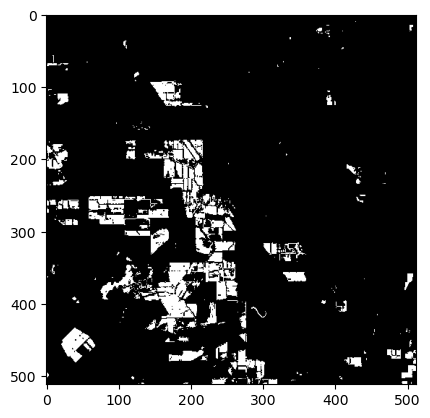

In [9]:
# 1=open water; 2=partial water; 252: snow/ice; 253: Cloud/Cloud Shadow and adjacent to cloud/cloud shadow; 254: Ocean Masked -
tmp = np.where(output_data==1, 1, 0) + np.where(output_data==2, 1, 0) + np.where(output_data==254, 1, 0)
water_gt = np.where(tmp>0, 1, 0)
plt.imshow(water_gt.squeeze(), cmap="gray")

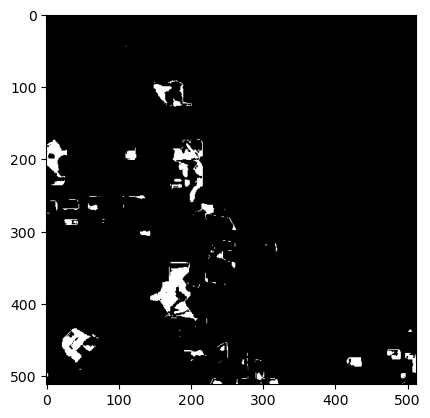

In [10]:
plt.imshow(filtered_water_mask.squeeze(), cmap='gray', vmin=0, vmax=1)

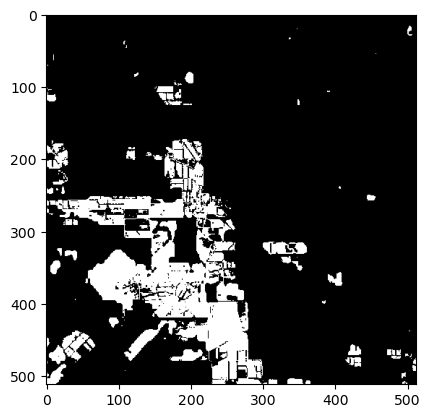

In [11]:
plt.imshow(fmask_water, cmap='gray')